# Import & Setting & Read

### import

In [2]:
import os
import numpy as np
import random

import matplotlib.pyplot as plt
import pandas as pd; pd.set_option("display.max_columns", None)
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import sentencepiece as spm

from Data import Data
from Pipeline import *
from CustomTransformer import *

### gpu setting

In [4]:
gpus = tf.config.list_physical_devices(device_type="GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_memory_growth(gpus[1], True)

# Random seed setting
SEED = 1
os.environ["PYTHONASHSEED"]= str(SEED)
os.environ["TF_DETERMINISTIC_OPS"]= "1"
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### read

In [10]:
# Read data
data = Data()
df_data = data.read_data(verbose=False)
df_data_prep = data.preprocess(df_data, verbose=True)

# Train test split
df_train = df_data_prep[df_data_prep["open_dy"] < "2022-01-01"].drop("open_dy", axis=1).reset_index(drop=True)
df_test = df_data_prep[df_data_prep["open_dy"] >= "2022-01-01"].drop("open_dy", axis=1).reset_index(drop=True)
print(df_train.shape)

/home/sh-sungho.park/anaconda3/envs/workspace/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


(859209, 19)


# Hyperparameter

In [7]:
BATCH_SIZE = 16
D_MODEL = 128 # 512
RATE = 0.1
NUM_LAYERS = 4 # 6
NUM_HEADS = 4 # 8
EPSIOLON = 1e-6
D_PFF = 512 # 2048

# BATCH_SIZE = 16
# D_MODEL = 512 # 512
# RATE = 0.1
# NUM_LAYERS = 6 # 6
# NUM_HEADS = 8 # 8
# EPSIOLON = 1e-6
# D_PFF = 2048 # 2048

# Pipeline

In [11]:
pipe = Pipeline([
    ("tokenize", Tokenize()),
    ("label_encoder", LabelEncode()),
    ("pivot", Pivot()),
])

df_train_dataset = pipe.fit_transform(df_train)
df_test_dataset = pipe.transform(df_test)

dataset, data_dict = data.get_tf_dataset(df_train_dataset, BATCH_SIZE)

/home/sh-sungho.park/Workspace/cgv/CGVFinal/Pipeline.py:74: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  def transform(self, x, y=None):


# Architecture

In [13]:
params = {
    "movie_name_vocab_size":pipe.named_steps["tokenize"].tokenizer.GetPieceSize(),
    "d_model": D_MODEL,
    "rate":RATE,
    "max_seq_len":max(df_train_dataset["movie_name"].str.len().max(), df_train_dataset["mov_tkt"].str.len().max()),
    "num_heads":NUM_HEADS,
    "num_layers":NUM_LAYERS,
    "epsilon":EPSIOLON,
    "d_pff":D_PFF,

    "data_dict":data_dict
          }

# Define input
enc_input_cols = ["movie_name", "site_name", "art_mov_yn", "mov_klj_yn", "nations", "genres1", "genres2", "director1", "director2", "actor1", "actor2", "actor3", "rating", "mov_knd_nm"]
dec_input_cols = ["mov_tkt", "daynames", "holiday"]
input_li = [tf.keras.layers.Input(shape=(None,)) for _ in enc_input_cols+dec_input_cols]

# Define model
custom_transformer = CustomTransformer(**params)
output = custom_transformer(*input_li, training=True)
model = tf.keras.models.Model(inputs=input_li, outputs=output)

# Train

In [14]:
def loss_function(y, pred):
  mask = 1 - tf.cast(tf.equal(0., y), tf.float32)
  loss = tf.square(y-pred)
  # loss *= mask
  # return tf.reduce_sum(loss) / tf.reduce_sum(mask)
  return tf.reduce_mean(loss)
    
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000.):
    super().__init__()
    self.d_model = tf.cast(d_model, tf.float32)
    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.pow(step, tf.cast(-0.5, tf.float32))
    arg2 = step * tf.pow(self.warmup_steps, tf.cast(-1.5, tf.float32))
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(params["d_model"])
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
total_batch_size = data_dict["mov_tkt_data"].shape[0]//BATCH_SIZE

2023-02-13 16:01:40.920991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-13 16:01:40.959461: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3187200000 Hz
2023-02-13 16:01:41.532867: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


0: 1/2243: 0.20276828110218048
Site 91 : 쥬만지- 넥스트 레벨


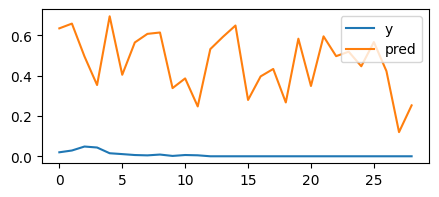

----------------------------------------------------------------------------------------------------
0: 1001/2243: 0.003296301467344165
Site 178 : 지오스톰


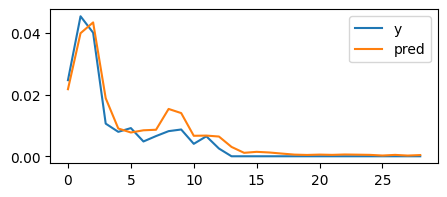

----------------------------------------------------------------------------------------------------
0: 2001/2243: 0.0017300562467426062
Site 15 : 82년생 김지영


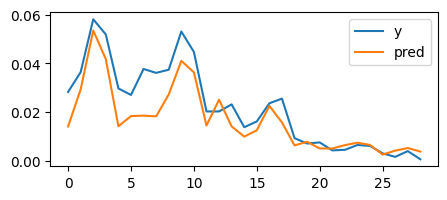

----------------------------------------------------------------------------------------------------
1: 1/2243: 6.996141019044444e-05
Site 176 : 슈퍼배드 3(더빙)


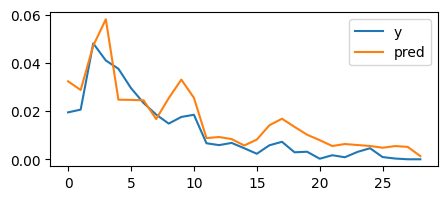

----------------------------------------------------------------------------------------------------
1: 1001/2243: 0.0001734209363348782
Site 43 : 킬러의 보디가드


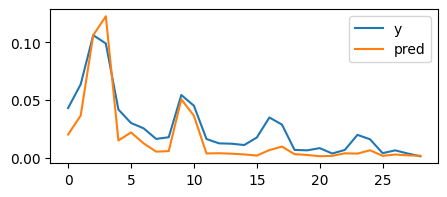

----------------------------------------------------------------------------------------------------
1: 2001/2243: 0.00016632481128908694
Site 165 : 레디 플레이어 원


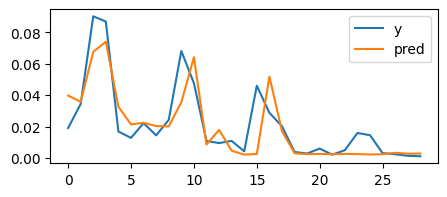

----------------------------------------------------------------------------------------------------
2: 1/2243: 0.00011298804020043463
Site 176 : 보안관


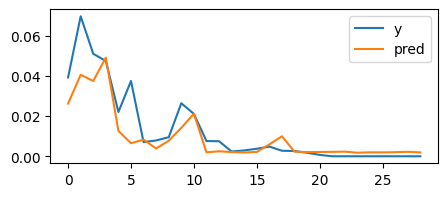

----------------------------------------------------------------------------------------------------
2: 1001/2243: 0.00011095590889453888
Site 73 : 캐리비안의 해적-죽은 자는 말이 없다


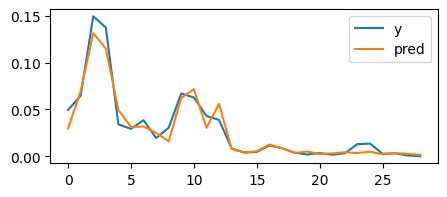

----------------------------------------------------------------------------------------------------
2: 2001/2243: 9.584065264789388e-05
Site 61 : 사바하


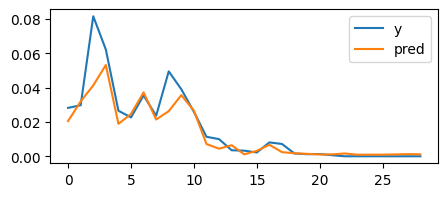

----------------------------------------------------------------------------------------------------
3: 1/2243: 0.00015608323155902326
Site 86 : 알라딘(4DX 2D)


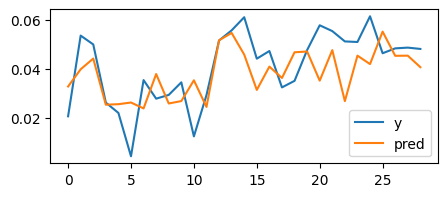

----------------------------------------------------------------------------------------------------
3: 1001/2243: 7.97579632489942e-05
Site 25 : 백두산


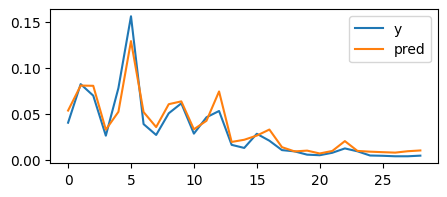

----------------------------------------------------------------------------------------------------
3: 2001/2243: 7.324582111323252e-05
Site 154 : 얼라이드


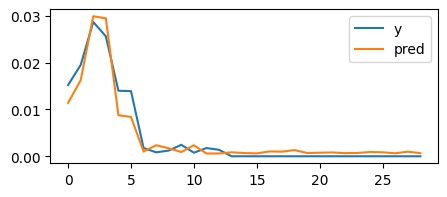

----------------------------------------------------------------------------------------------------
4: 1/2243: 4.616037767846137e-05
Site 85 : 베놈 2-렛 데어 비 카니지


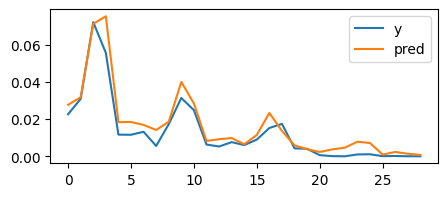

----------------------------------------------------------------------------------------------------
4: 1001/2243: 6.294003833318129e-05
Site 190 : 꾼


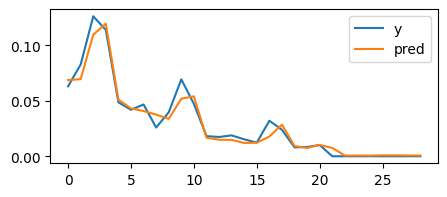

----------------------------------------------------------------------------------------------------
4: 2001/2243: 5.969891572021879e-05
Site 209 : 리얼


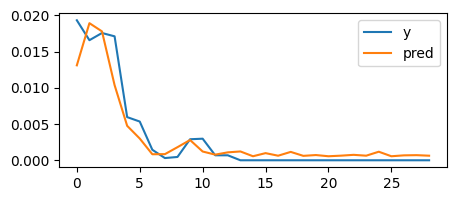

----------------------------------------------------------------------------------------------------
5: 1/2243: 4.587350122164935e-05
Site 200 : 스머프-비밀의 숲(더빙)


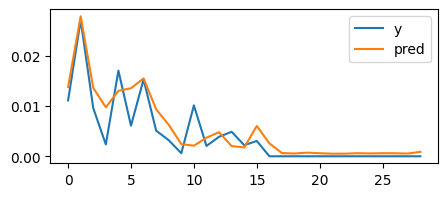

----------------------------------------------------------------------------------------------------
5: 1001/2243: 5.2374736696947366e-05
Site 86 : 알리타-배틀 엔젤(SCREENX 2D)


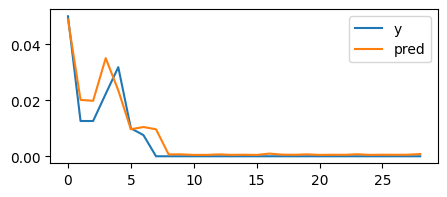

----------------------------------------------------------------------------------------------------
5: 2001/2243: 5.5687836720608175e-05
Site 127 : 베이블레이드 버스트 갓-갓 발키리의 탄생(더빙)


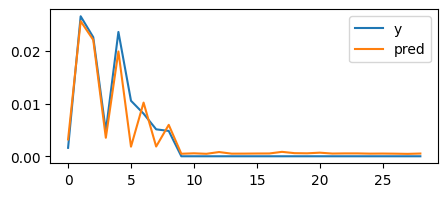

----------------------------------------------------------------------------------------------------
6: 1/2243: 1.651658385526389e-05
Site 17 : 분노의 질주- 홉스&쇼


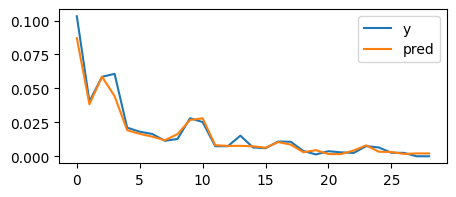

----------------------------------------------------------------------------------------------------
6: 1001/2243: 5.522526043932885e-05
Site 206 : 너의 결혼식


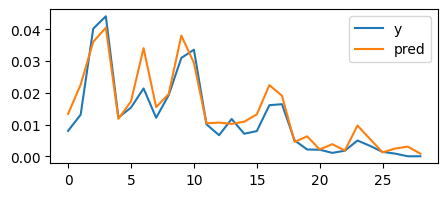

----------------------------------------------------------------------------------------------------
6: 2001/2243: 5.227548172115348e-05
Site 150 : 미드웨이


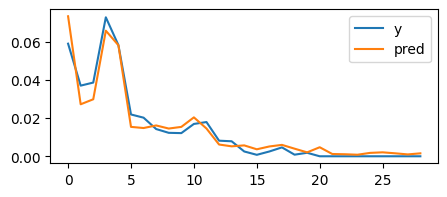

----------------------------------------------------------------------------------------------------
7: 1/2243: 2.2572159650735557e-05
Site 204 : 재심


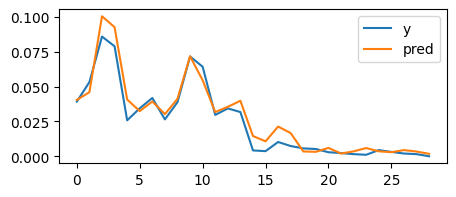

----------------------------------------------------------------------------------------------------
7: 1001/2243: 4.7919678763719276e-05
Site 181 : 스파이더맨-홈커밍


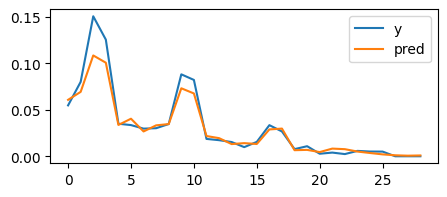

----------------------------------------------------------------------------------------------------
7: 2001/2243: 4.770483428728767e-05
Site 127 : 신비아파트-금빛 도깨비와 비밀의 동굴(더빙)


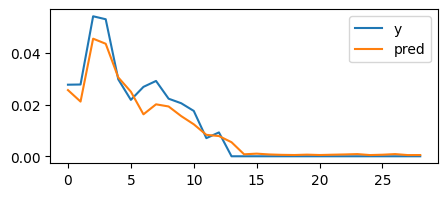

----------------------------------------------------------------------------------------------------
8: 1/2243: 5.498929021996446e-05
Site 101 : 탐정-리턴즈


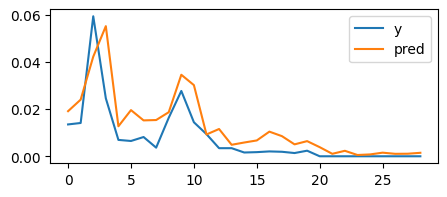

----------------------------------------------------------------------------------------------------
8: 1001/2243: 4.651088602258824e-05
Site 72 : 더넌


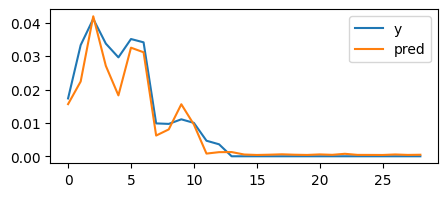

----------------------------------------------------------------------------------------------------
8: 2001/2243: 4.6299486712086946e-05
Site 73 : 블랙 팬서


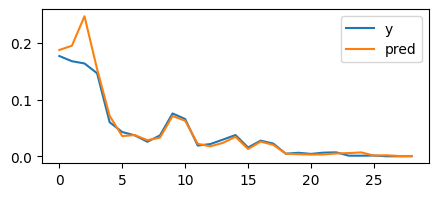

----------------------------------------------------------------------------------------------------
9: 1/2243: 5.439599772216752e-05
Site 3 : 변신


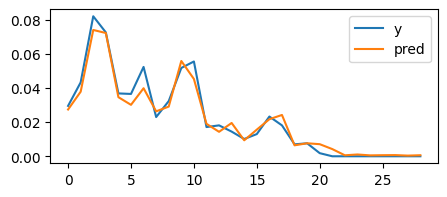

----------------------------------------------------------------------------------------------------
9: 1001/2243: 4.405295476317406e-05
Site 110 : 크루엘라


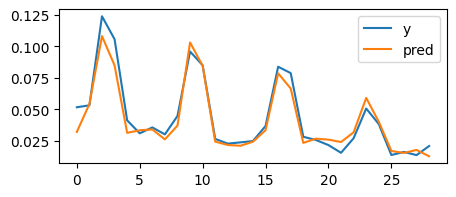

----------------------------------------------------------------------------------------------------
9: 2001/2243: 4.329552757553756e-05
Site 189 : 주먹왕 랄프 2-인터넷 속으로(더빙)


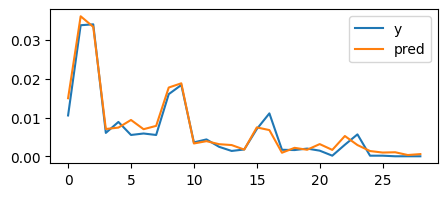

----------------------------------------------------------------------------------------------------
10: 1/2243: 3.341601404827088e-05
Site 98 : 오케이 마담


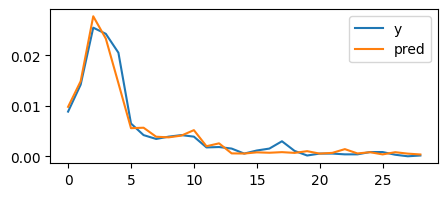

----------------------------------------------------------------------------------------------------
10: 1001/2243: 4.1480165236862376e-05
Site 50 : 사바하


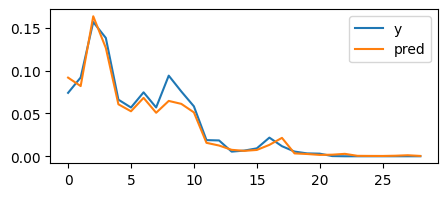

----------------------------------------------------------------------------------------------------
10: 2001/2243: 4.397599332151003e-05
Site 69 : 미녀와 야수(더빙)


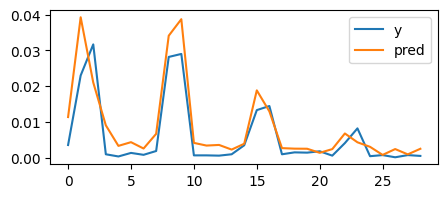

----------------------------------------------------------------------------------------------------
11: 1/2243: 2.288650102855172e-05
Site 165 : 목격자


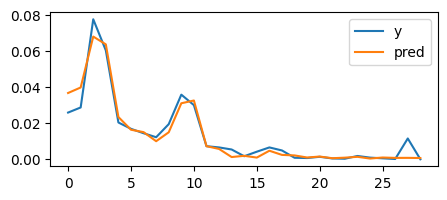

----------------------------------------------------------------------------------------------------
11: 1001/2243: 4.204879587632604e-05
Site 164 : 싱크홀


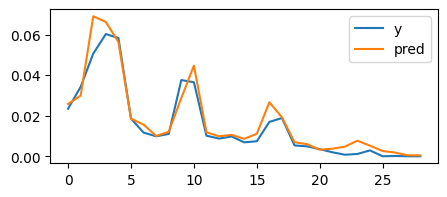

----------------------------------------------------------------------------------------------------
11: 2001/2243: 4.2349078285042197e-05
Site 213 : 마약왕


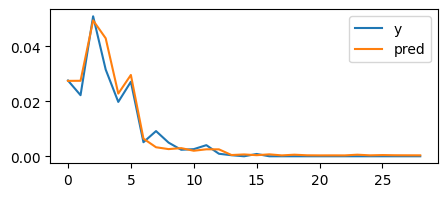

----------------------------------------------------------------------------------------------------
12: 1/2243: 2.7021736968890764e-05
Site 183 : 7년의 밤


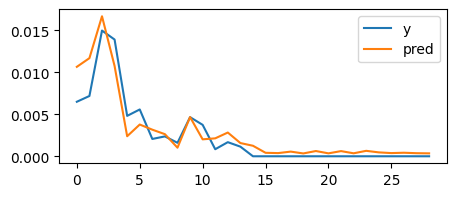

----------------------------------------------------------------------------------------------------
12: 1001/2243: 4.036284735775553e-05
Site 95 : 공작


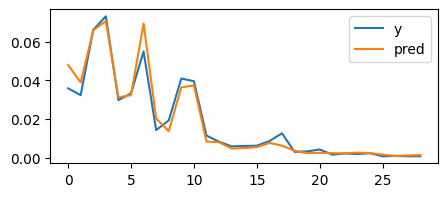

----------------------------------------------------------------------------------------------------
12: 2001/2243: 4.066676410729997e-05
Site 42 : 보스 베이비(더빙)


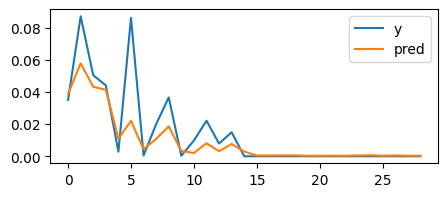

----------------------------------------------------------------------------------------------------
13: 1/2243: 5.858977237949148e-05
Site 18 : 히트맨


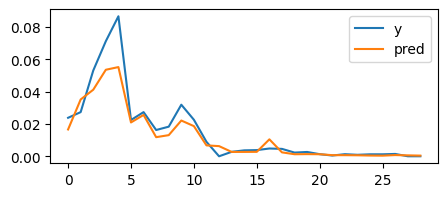

----------------------------------------------------------------------------------------------------
13: 1001/2243: 3.972947160946205e-05
Site 4 : 보통사람


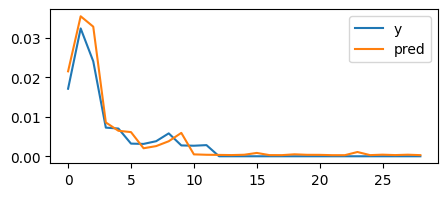

----------------------------------------------------------------------------------------------------
13: 2001/2243: 3.942691546399146e-05
Site 65 : 삼진그룹 영어토익반


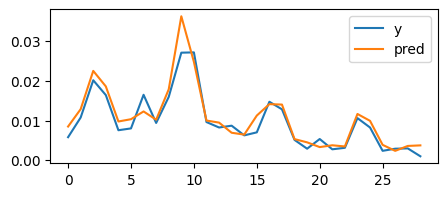

----------------------------------------------------------------------------------------------------
14: 1/2243: 2.8952603315701708e-05
Site 5 : 오션스8


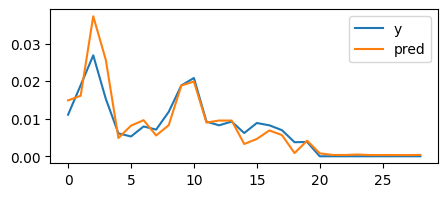

----------------------------------------------------------------------------------------------------
14: 1001/2243: 3.78963777620811e-05
Site 174 : 라이온 킹


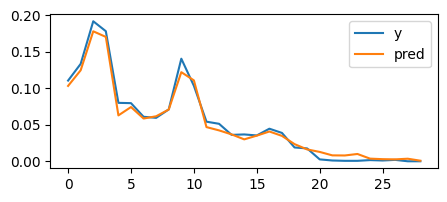

----------------------------------------------------------------------------------------------------
14: 2001/2243: 3.817264223471284e-05
Site 127 : 12 솔져스(IMAX 2D)


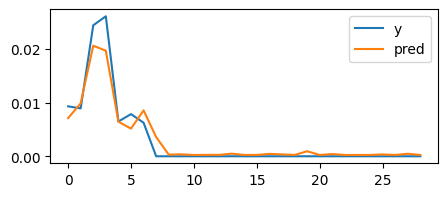

----------------------------------------------------------------------------------------------------
15: 1/2243: 4.104101753910072e-05
Site 50 : 감쪽같은 그녀


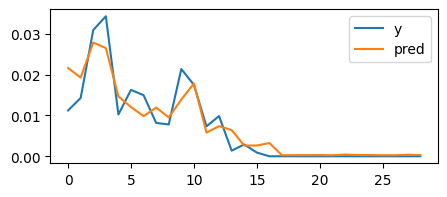

----------------------------------------------------------------------------------------------------
15: 1001/2243: 3.776041921810247e-05
Site 174 : 덩케르크


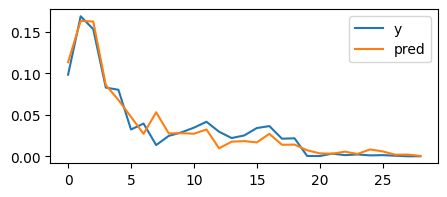

----------------------------------------------------------------------------------------------------
15: 2001/2243: 3.730218668351881e-05
Site 186 : 닥터 두리틀(자막)


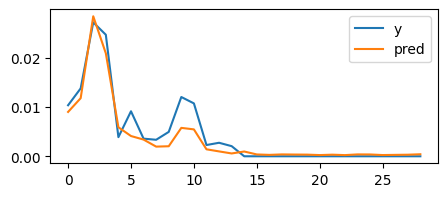

----------------------------------------------------------------------------------------------------
16: 1/2243: 1.8490338334231637e-05
Site 187 : 신의 한 수- 귀수편


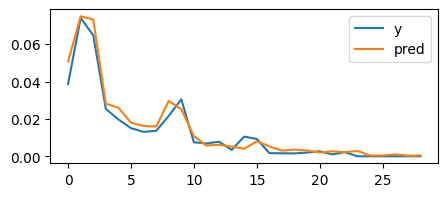

----------------------------------------------------------------------------------------------------
16: 1001/2243: 3.603883305913769e-05
Site 72 : 12 솔져스


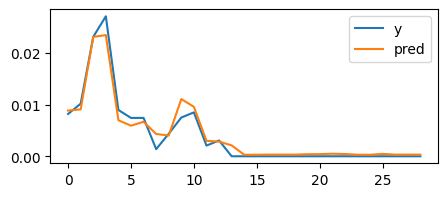

----------------------------------------------------------------------------------------------------
16: 2001/2243: 3.735391146619804e-05
Site 150 : 더킹


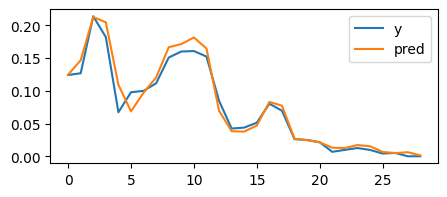

----------------------------------------------------------------------------------------------------
17: 1/2243: 4.052945951116271e-05
Site 72 : 블랙 팬서


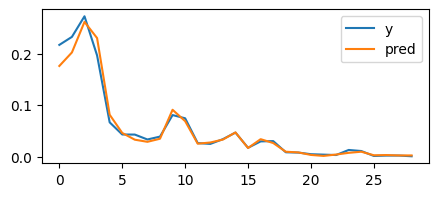

----------------------------------------------------------------------------------------------------
17: 1001/2243: 3.545332947396673e-05
Site 205 : 아이캔스피크


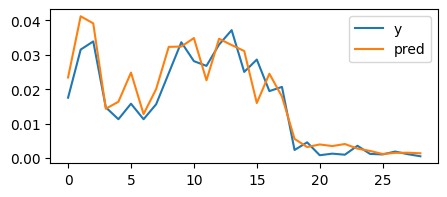

----------------------------------------------------------------------------------------------------
17: 2001/2243: 3.5760462196776643e-05
Site 131 : 알리타-배틀 엔젤(4DX 3D)


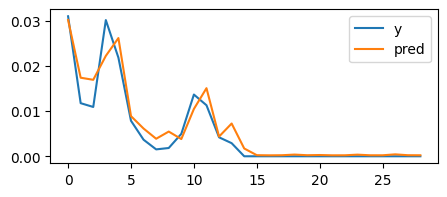

----------------------------------------------------------------------------------------------------
18: 1/2243: 3.261506208218634e-05
Site 69 : 박열


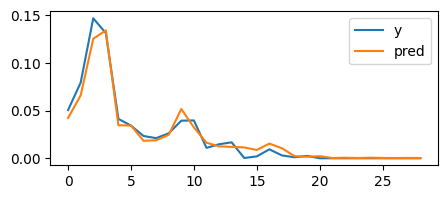

----------------------------------------------------------------------------------------------------
18: 1001/2243: 3.5407618270255625e-05
Site 147 : 스카이스크래퍼


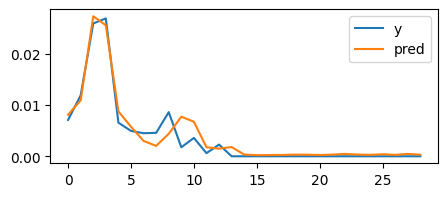

----------------------------------------------------------------------------------------------------
18: 2001/2243: 3.603165168897249e-05
Site 131 : 분노의 질주- 홉스&쇼


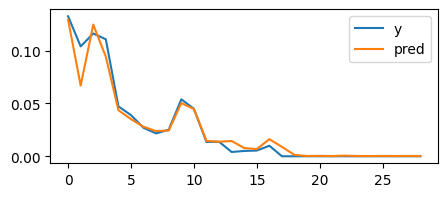

----------------------------------------------------------------------------------------------------
19: 1/2243: 3.4398330171825364e-05
Site 73 : 메리와 마녀의 꽃(더빙)


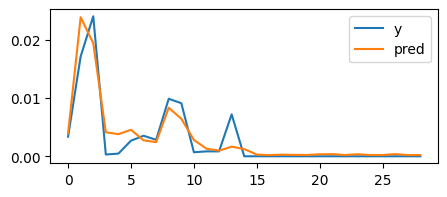

----------------------------------------------------------------------------------------------------
19: 1001/2243: 3.553488204488531e-05
Site 78 : 뷰티풀 투모로우


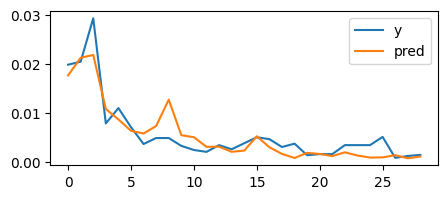

----------------------------------------------------------------------------------------------------
19: 2001/2243: 3.5824319638777524e-05
Site 53 : 노무현입니다


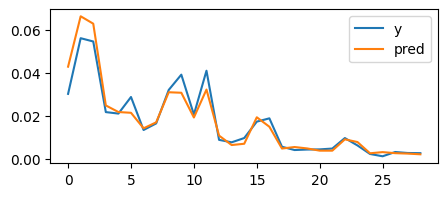

----------------------------------------------------------------------------------------------------


In [15]:
@tf.function
def train_step(input, target):
    with tf.GradientTape() as tape:
        pred = model(input, target)
        pred = tf.squeeze(pred)
        loss = loss_function(target, pred)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, target, pred


site_decoder = {idx:name for name, idx in pipe.named_steps["label_encoder"].encoder_li[0].items()}
for e in range(20):
    loss_li = []
    for n_batch, (input, target) in enumerate(dataset):
        loss, target, pred = train_step(input, target)
        loss_li.append(loss)

        if n_batch % 1000 == 0:
            print(f"{e}: {n_batch+1}/{total_batch_size}: {f'{np.mean(loss_li):,}'}")
            # print(site_decoder[input[1][-1].numpy()[0]], ":", pipe.named_steps["tokenize"].tokenizer.DecodeIds(input[0][-1].numpy().astype(np.int32).tolist()))
            print("Site", int(input[1][-1].numpy()[0]), ":", pipe.named_steps["tokenize"].tokenizer.DecodeIds(input[0][-1].numpy().astype(np.int32).tolist()))
            plt.figure(figsize=(5,2))
            plt.plot(target[-1], label="y")
            plt.plot(pred[-1], label="pred")
            plt.legend()
            plt.show()
            print("-"*100)